In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## 1 K-Means
### 1.3 Implementation
Implement the K-Means algorithm.
```python
def KMeans(mX, K):
```
**Notes**:
* The algorithm halts when no update occur.  
* Implement the [K-Means++](https://en.wikipedia.org/wiki/K-means%2B%2B) initialization.  
Consider writing the K-Means++ initialization as a separate function.
------------------------------------------------------------------------------------------------------

In [3]:
####################################################
##--Your code here...
def KMeans(mX, K):
    '''
    Apply K-Means
    Args:
        mX   - Input data,         mX.shape = (d, N)
        K    - Number of clusters, positive integer
    Output:
        vIdx - Index of the cluster each point belongs to, vIdx.shape = (N,)
        mMu  - Clusters' centers,                          mMu.shape  = (d, K)
        
    '''
    centroids = kmean_plu_pus_init(mX, K)
    prev_cent = np.zeros((K, len(centroids[0])))
    loop_counter = 0
    while not np.array_equal(centroids, prev_cent):
        
        prev_cent = centroids.copy()
        
        dist_matrix = lp_distance(mX, centroids)
        classes = np.argmin(dist_matrix, axis=0)
        for i in range(K):
            centroids[i] = np.mean(mX[classes == i], axis=0)
        
        loop_counter += 1
        
    return centroids, classes

def kmean_plu_pus_init(mX, K):

    first_index = np.random.randint(0, mX.shape[0])
    centroids = np.zeros(shape=(K, mX.shape[1]))
    
    centroids[0] =  mX[first_index]
    
    calculated_centroids = 1
    while calculated_centroids < K:
        dis = lp_distance(mX, centroids)
        points_min_distances = np.min(dis, axis=0)

        total_distances = np.sum(points_min_distances)
        probs = points_min_distances/total_distances

        next_centroid_index = np.random.choice(range(0, points_min_distances.shape[0]), size=1, replace=False, p=probs)[0]
        centroids[calculated_centroids] = mX[next_centroid_index]
        calculated_centroids += 1
        
    return centroids
        

def lp_distance(X, centroids):
    
    mtrx = np.array(X).astype(float)
    distances = np.zeros(shape=(len(centroids), X.shape[0]))
    for (centroid_index, centroid) in enumerate(centroids):
        val = np.power(np.absolute(mtrx-centroid),2.0).sum(axis=1)
        distances[centroid_index] = np.power(val,(1./2.0))
        
    return distances


### 1.4 Super-pixels
1. Load the `Fruits.jpeg` image and covert it to NumPy ndarray `mI`:
$$\boldsymbol{I}\in\mathbb{R}^{\text{height}\times\text{width}\times3}$$
2. Use the LAB color space (instead of RGB) (`mLAB`).
3. Create a new "image" `mX` such that:
$$\boldsymbol{X}\in\mathbb{R}^{\text{height}\times\text{width}\times5}$$
where:
    * The first 3 channels are the LAB image.
    * The 4th channel is the $x$ position.
    * The 5th channel is the $y$ position.
4. Apply K-Means to the pixels of `mX` (set a reasonable $K$).  
    You may use your own implementation or sk-learn implementation.
5. Create a mask image `mMask` such that:
$$\boldsymbol{M}\in\mathbb{N}_0^{\text{height}\times\text{width}}$$
where each pixel in `mMask` is the cluster index of the corresponding pixel in `mI`.
6. Plot the segmentation (Superpixels) map.

**Tips:**
* To apply K-means you first need to `reshape` the 3D matrix (tensor) `mX`.
* Try different weights for the color space (LAB) and the spatial space (XY).

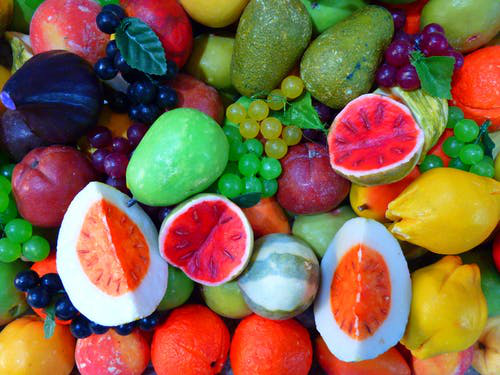

In [4]:
from PIL                  import Image
from skimage              import color
from skimage.segmentation import mark_boundaries

oImage = Image.open('Fruits.jpeg')
oImage

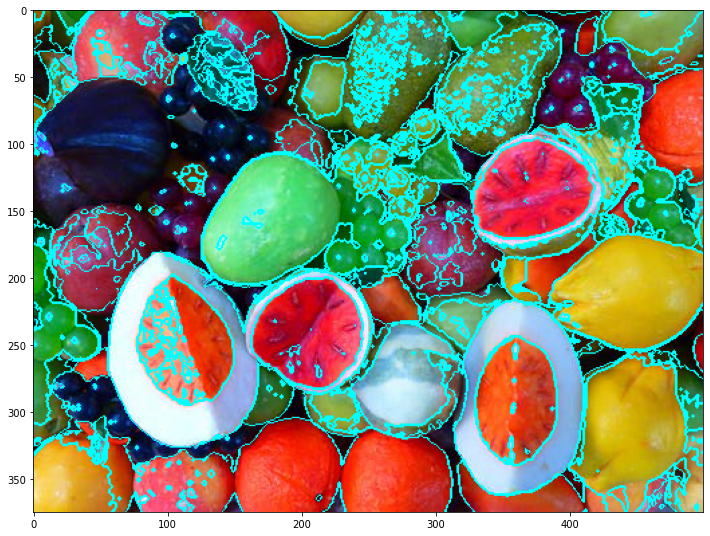

In [5]:
mI   = np.array(oImage)
mLAB = color.rgb2lab(mI)

####################################################

data = np.zeros((mLAB.shape[0], mLAB.shape[1], 5))

data[:, :, 0:3] = mLAB

y = np.zeros((mLAB.shape[0], mLAB.shape[1]))
for i in range(mLAB.shape[0]):
    for j in range(mLAB.shape[1]):
        data[i,j, 3] = (j/(mLAB.shape[1]-1))
        data[i,j, 4] = (i/(mLAB.shape[0]-1))
        

data = data.reshape(-1, 5)

centroids, classes = KMeans(data, 6)


mMask = classes.reshape(mI.shape[0], mI.shape[1])

mO = mark_boundaries(mI, mMask, color=(0,1,1))

plt.figure(figsize=(12, 12))
plt.imshow(mO)
plt.show()

####################################################


------------------------------------------------------------------------------------------------------
## 2 GMM
The GMM algorithm aims to maximize the (log) likelihood objective:
$$\arg\max_{\left\{ \left(w_{k},\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_{k}\right)\right\} _{k=1}^{K}}f=\arg\max_{\left\{ \left(w_{k},\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_{k}\right)\right\} _{k=1}^{K}}\sum_{i=1}^{N}\log\left(\sum_{k=1}^{K}w_{k}\mathcal{N}_d\left(\boldsymbol{x}_{i};\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_{k}\right)\right)$$
where:
$$\mathcal{N}_{d}\left(\boldsymbol{x};\boldsymbol{\mu},\boldsymbol{\Sigma}\right)=\frac{1}{\sqrt{\left(2\pi\right)^{d}\left|\boldsymbol{\Sigma}\right|}}\exp\left(-\frac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^{T}\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)\right)$$
### 2.3 Implementation
Implement the GMM algorithm.
```python
def GMM(mX, K, ε=1e-6, maxIter=100):
```
**Notes**:
* Stopping criteria:
    * The objective $f$ has changed less than $\epsilon$.
    * Maximum number of iteration.
* The index $s$ of the point $\boldsymbol{x}_i$ is defined by:
$$\boldsymbol{x}_{i}\in\mathcal{D}_{s} \iff s=\arg\max_{k}w_{k}\mathcal{N}_d\left(\boldsymbol{x}_{i},\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_{k}\right)$$
* Use [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) and avoid `for` loops in Step II (parameters update). 


In [6]:
####################################################
##--Your code here...


from scipy.stats import multivariate_normal

def GMM(mX, K, ε=1e-6, maxIter=100):
    '''
    Apply GMM
    Args:
        mX      - Input data,                   mX.shape = (d, N)
        K       - Number of clusters,           positive integer
        ε       - Stopping criterion threshold, positive real
        maxIter - Maximum number of iterations, positive integer
    Output:
        vIdx - Index of the cluster each point belongs to, vIdx.shape = (N,)
        vW   - The weight of each Gaussian,                vW.shape   = (K,)
        mMu  - Centers,                                    mMu.shape  = (d, K)
        mSig - Covariance,                                 mSig.shape = (d, d, K)
    '''

    shape = mX.shape
    n, m = shape
    phi = np.full(shape=K, fill_value=1 / K)
    weights = np.full(shape=shape, fill_value=1.0 / K)
    random_row = np.random.randint(low=0, high=n, size=K)
    mu = [mX[row_index, :] for row_index in random_row]
    sigma = [np.cov(mX.T) for _ in range(K)]

    for iteration in range(maxIter):
        #print('iteration {}'.format(iteration))
        #estep
        likelihood = np.zeros((n, K))
        for i in range(K):
            distribution = multivariate_normal(mean=mu[i], cov=sigma[i])

            likelihood[:, i] = distribution.pdf(mX)

        numerator = likelihood * phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        phi = weights.mean(axis=0)
        # mstep
        for i in range(K):
            weight = weights[:, [i]]
            total_weight = weight.sum()
            mu[i] = (mX * weight).sum(axis=0) / total_weight
            sigma[i] = np.cov(mX.T,aweights=(weight / total_weight).flatten(),bias=True)

    likelihood = np.zeros((n, K))
    for i in range(K):
        distribution = multivariate_normal(mean=mu[i], cov=sigma[i])

        likelihood[:, i] = distribution.pdf(mX)

    classes = np.argmax(likelihood, axis=1)

    return classes, weight, mu, sigma






    

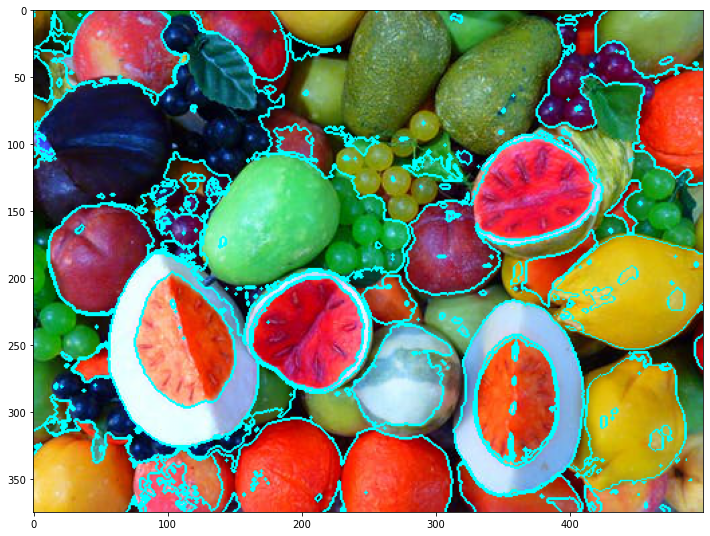

In [7]:
classes, weight, mu, sigma = GMM(data, 6)
mMask = classes.reshape(mI.shape[0], mI.shape[1])

mO = mark_boundaries(mI, mMask, color=(0,1,1))

plt.figure(figsize=(12, 12))
plt.imshow(mO)
plt.show()


------------------------------------------------------------------------------------------------------
Consider the following data:

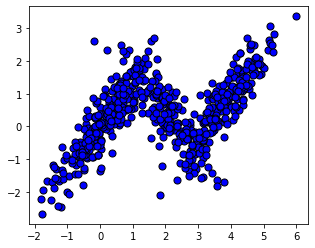

In [8]:
import scipy.stats
import scipy as sp

np.random.seed(0)

N1    = 250
N2    = 150
N3    = 200

vMu1  = np.array([0, 0  ])
vMu2  = np.array([2, 0.5])
vMu3  = np.array([4, 1  ])

mSig1 = .5 * np.array([[1.00, 1.25],
                       [1.25, 2.00]])

mSig2 = .5 * np.array([[ 1.00, -1.25],
                       [-1.25,  2.00]])

mSig3 = .5 * np.array([[1.00, 1.25],
                       [1.25, 2.00]])

mX1 = sp.stats.multivariate_normal.rvs(mean=vMu1, cov=mSig1, size=N1)
mX2 = sp.stats.multivariate_normal.rvs(mean=vMu2, cov=mSig2, size=N2)
mX3 = sp.stats.multivariate_normal.rvs(mean=vMu3, cov=mSig3, size=N3)
mX  = np.r_[mX1, mX2, mX3].T

plt.figure (figsize=(5, 4))
plt.scatter(mX[0,:], mX[1,:], s=50, edgecolors='k', color='b')
plt.axis   ('equal')
plt.show   ()

### 2.4 Compare K-Means to GMM 
* Set $K=3$ and apply K-Means and GMM to the above dataset.
* Repeat several times.

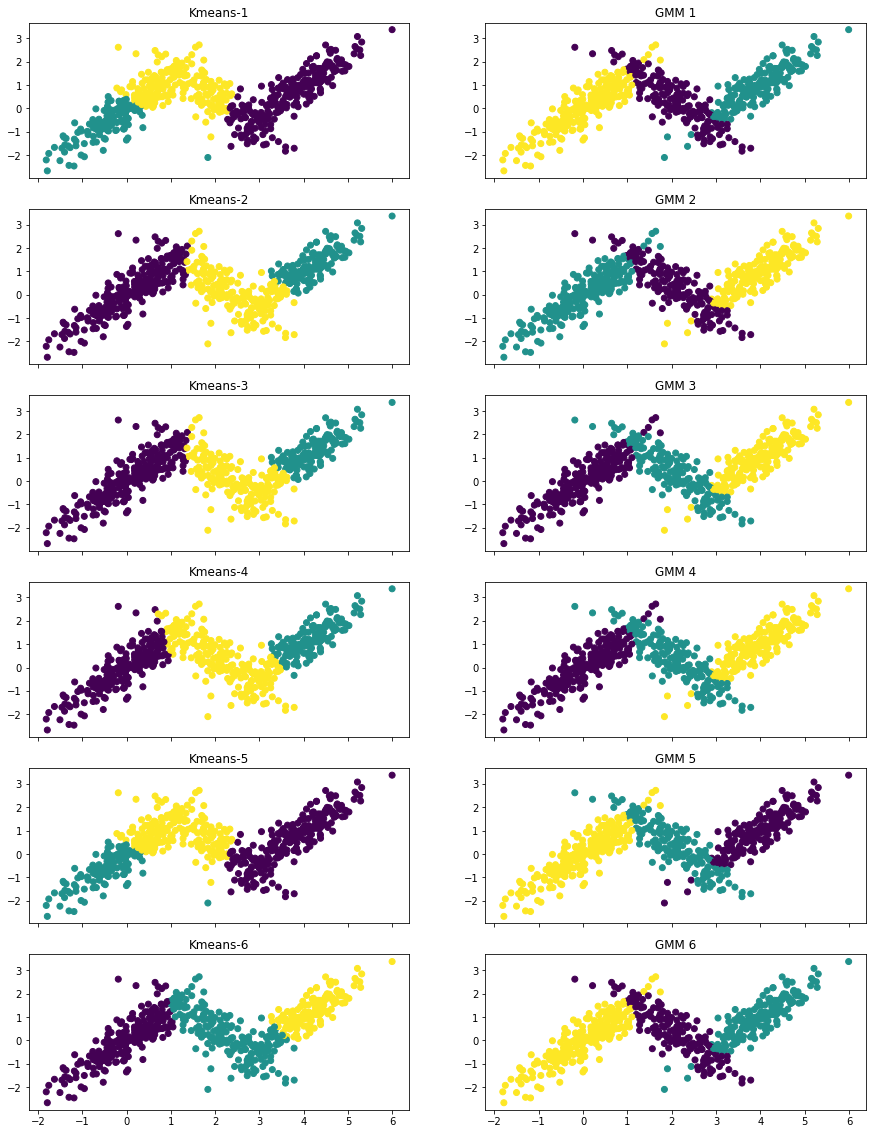

In [10]:

####################################################
K = 3

data = np.array(mX.T.copy())
rounds = 6 

fig, axes = plt.subplots(rounds, 2, sharex=True, sharey=False, figsize=(15,20))
for i in range(rounds):
    
    centroids, classes = KMeans(data, 3)
    axes[i,0].scatter(data[:, 0], data[:, 1], c = classes)
    axes[i,0].set_title('Kmeans-{}'.format(i + 1))
    
    classes, w, mu, sigma = GMM(data, 3)
    axes[i,1].scatter(data[:, 0], data[:, 1], c = classes)
    axes[i,1].set_title('GMM {}'.format(i +1))
    

####################################################

------------------------------------------------------------------------------------------------------
## 4 DBSCAN
### 4.1 Implementation
Implement the DBSCAN algorithm.
```python
def DBSCAN(mX, Z, r):
```
**Notes**:
* Noise points should have index `-1`.
* Implement an auxiliary function to compute connected components (using BFS or DFS).

In [11]:
####################################################

class Node:

    def __init__(self, index):
        self.index = index
        self.neighbors = None
        self.cluster = None

    def is_core_point(self):
        return self.neighbors is not None

    def __eq__(self, other):
        return self.index == other.index

    def __hash__(self):
        return hash(self.index)
    
def bfs(node, queue, cluster_id):
    visited = []
    visited.append(node)

    updates = 0
    if node.neighbors is None or node.cluster is not None:
        return updates

    queue.append(node)

    while len(queue) > 0:
        s = queue.pop(0)

        if s.neighbors is None:
            continue

        for neighbour in s.neighbors:
            if neighbour.cluster is None:
                neighbour.cluster = cluster_id
                updates += 1

            if  neighbour.is_core_point() and neighbour not in visited:
                queue.append(neighbour)
                visited.append(neighbour)

    return updates



def DBSCAN(mX, Z, r):
    '''
    Apply DBSCAN
    Args:
        mX   - Input data,                                   mX.shape = (d, N)
        Z    - Number of points required to be a core point, positive integer
        r    - Neighborhood radius,                          positive real.
    Output:
        vIdx - Index of the cluster each point belongs to,   vIdx.shape = (N,)
    '''
    
    mX = mX.T
    
    index_to_node = {i: Node(i) for i in range(mX.shape[0])}

    for i in range(mX.shape[0]):

        node = index_to_node[i]

        point_distances = np.linalg.norm(mX[i, :] - mX, axis=1)

        neighbors = np.where(point_distances <= r)[0]
        number_of_points_in_range = neighbors.shape[0] -1

        if number_of_points_in_range >= Z:
            node.neighbors = [index_to_node[node_index] for node_index in neighbors if node_index != node.index]
    
    cluster_id = 0

    for node in index_to_node.values():
        
        markes_nodes = bfs(node, [], cluster_id)

        if markes_nodes > 0:
            cluster_id += 1

    clusters = [index_to_node[i].cluster if index_to_node[i].cluster is not None else -1 for i in range(mX.shape[0])]
    
    return clusters
    
    
    
####################################################


/home/gabib/anaconda3/envs/cv22/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


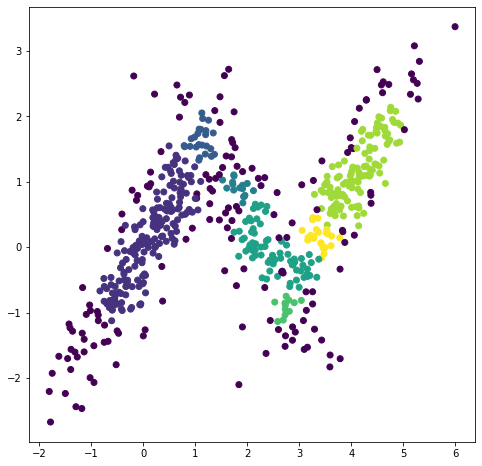

In [12]:

db_scan_classes = DBSCAN(mX, 6,0.2)

fig, axe = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(8,8))

axe.scatter(x=data[:, 0], y=data[:, 1], c = db_scan_classes)
    
fig.show()


### 4.2 Comparison
Consider the following datasets:

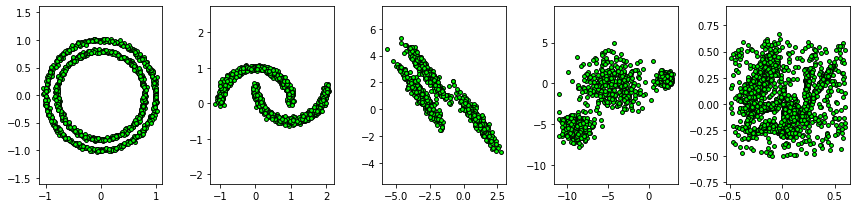

In [13]:
from sklearn import datasets

np.random.seed(0)

N   = 1000
A   = np.array([[0.6, -0.6],
                [-0.4, 0.8]]);
mX1 = datasets.make_circles(n_samples=N, noise=0.02)      [0]
mX2 = datasets.make_moons  (n_samples=N, noise=0.05)      [0]
mX3 = datasets.make_blobs  (n_samples=N, random_state=170)[0] @ A
mX4 = datasets.make_blobs  (n_samples=N, random_state=170, cluster_std=[.8, 2, .4])[0] 
mX5 = np.load('clusterable_data.npy')

lDatasets = [mX1, mX2, mX3, mX4, mX5]

fig, _ = plt.subplots(1, 5, figsize=(12, 3))
for ii, ax in enumerate(fig.axes):
    mXi = lDatasets[ii]
    ax.scatter(*mXi.T, c='lime', s=15, edgecolor='k')
    ax.axis   ('equal')
    
plt.tight_layout()
plt.show        ()

Apply the following methods and compare the obtained results:
* **K-Means**
* **GMM**
* **DBSCAN**
* Hierarchical clustering
* HDBSCAN

For the first three, use your own implementation.  
For the last two, you may use existing libraries: [Hierarchical clustering (sk-learn)](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering), [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/index.html).
    
**Note:** The datasets are transposed, e.g `mX1.shape = (1000, 2)`.

In [14]:
from hdbscan import HDBSCAN
from sklearn.cluster import AgglomerativeClustering

In [16]:
def predict(data, k):

    
    _, classes_kmeans = KMeans(data.T, k)
    classes_gmm, _, _, _ = GMM(data.T, k)
    classes_dbscan = DBSCAN(data, k, 0.1)
    classes_hdbscan = HDBSCAN(min_cluster_size=20, min_samples=5).fit_predict(data.T)
    classes_agglomerative_clustering = AgglomerativeClustering().fit(data.T).labels_
    
    return classes_kmeans, classes_gmm, classes_dbscan, classes_hdbscan,  classes_agglomerative_clustering

In [17]:
####################################################


classes_kmeans1, classes_gmm1, classes_dbscan1, classes_hdbscan1,  classes_agglomerative_clustering1 = predict(mX1.T, 2)
classes_kmeans2, classes_gmm2, classes_dbscan2, classes_hdbscan2,  classes_agglomerative_clustering2 = predict(mX2.T, 2)
classes_kmeans3, classes_gmm3, classes_dbscan3, classes_hdbscan3,  classes_agglomerative_clustering3 = predict(mX3.T, 3)
classes_kmeans4, classes_gmm4, classes_dbscan4, classes_hdbscan4,  classes_agglomerative_clustering4 = predict(mX4.T, 5)
classes_kmeans5, classes_gmm5, classes_dbscan5, classes_hdbscan5,  classes_agglomerative_clustering5 = predict(mX5.T, 5)



####################################################

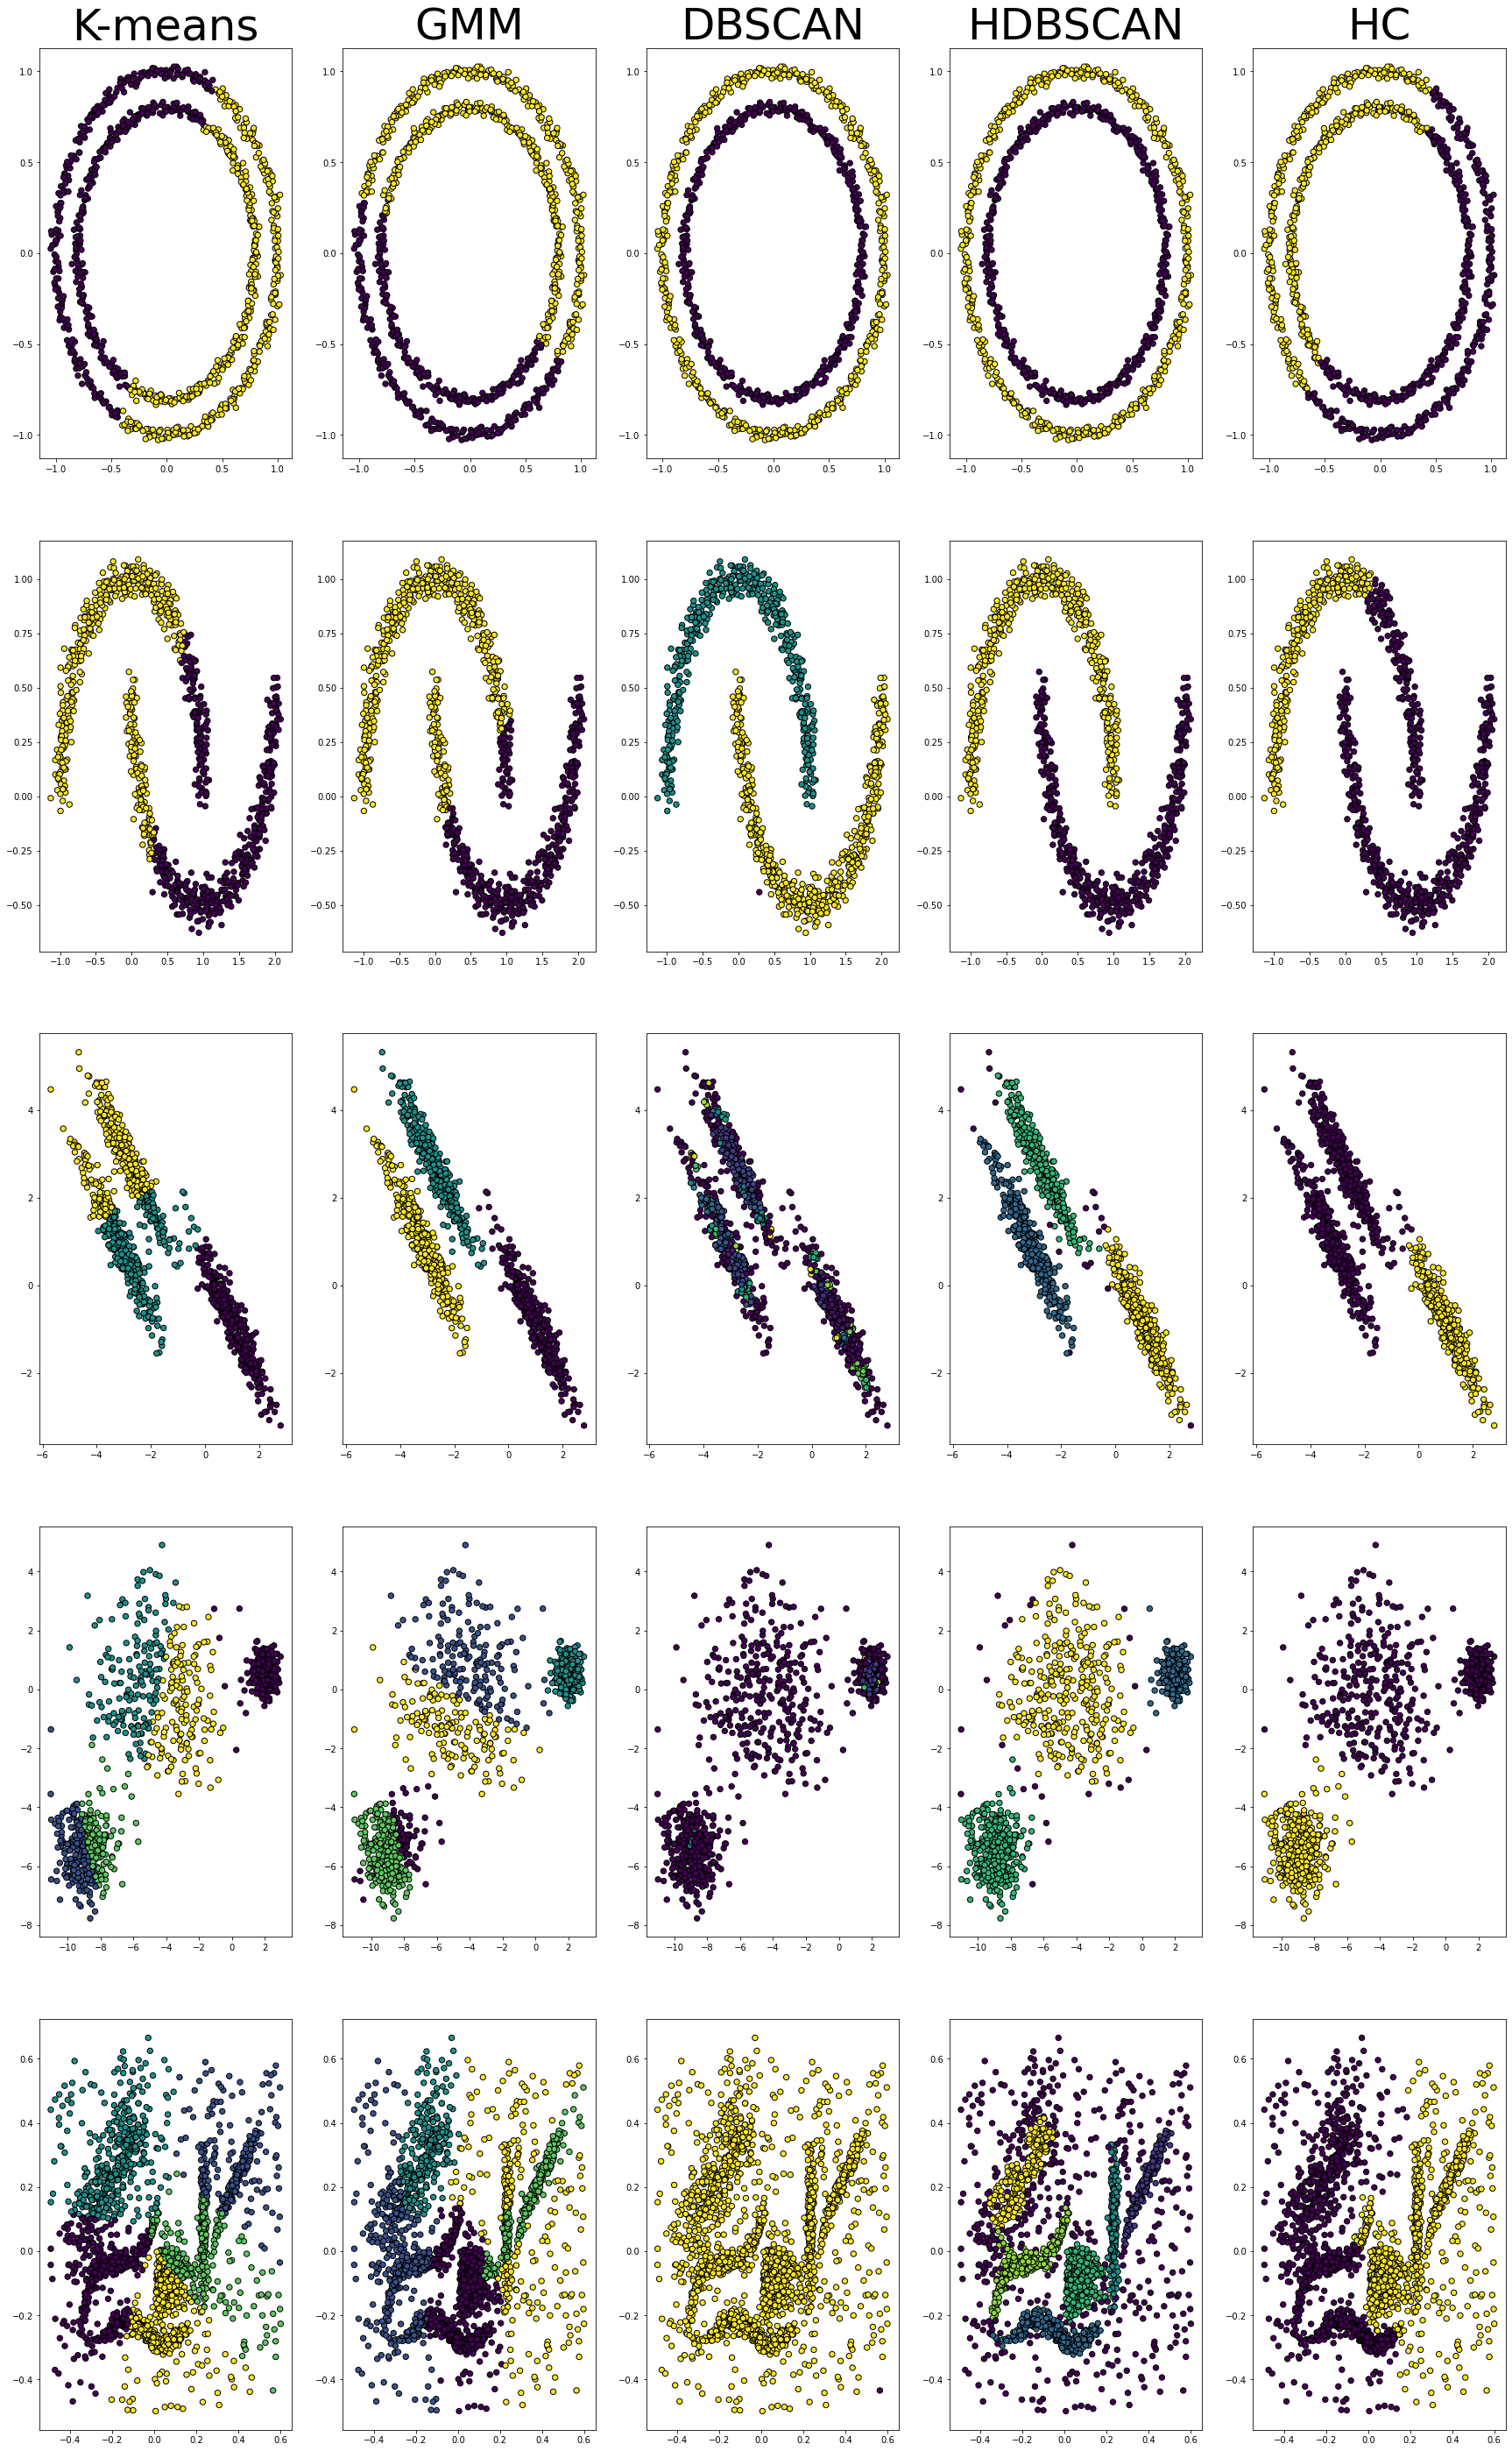

In [18]:
fig, axes = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(30,50))

axes[0,0].set_title('K-means', fontsize=50)
axes[0,1].set_title('GMM', fontsize=50)
axes[0,2].set_title('DBSCAN', fontsize=50)
axes[0,3].set_title('HDBSCAN', fontsize=50)
axes[0,4].set_title('HC', fontsize=50)

axes[0, 0].scatter(mX1[:, 0], mX1[:, 1], c = classes_kmeans1, s=40, edgecolor='k')
axes[0, 1].scatter(mX1[:, 0], mX1[:, 1], c = classes_gmm1, s=40, edgecolor='k')  
axes[0, 2].scatter(mX1[:, 0], mX1[:, 1], c = classes_dbscan1, s=40, edgecolor='k')
axes[0, 3].scatter(mX1[:, 0], mX1[:, 1], c = classes_hdbscan1, s=40, edgecolor='k')
axes[0, 4].scatter(mX1[:, 0], mX1[:, 1], c = classes_agglomerative_clustering1, s=40, edgecolor='k')

axes[1, 0].scatter(mX2[:, 0], mX2[:, 1], c = classes_kmeans2, s=40, edgecolor='k')
axes[1, 1].scatter(mX2[:, 0], mX2[:, 1], c = classes_gmm2, s=40, edgecolor='k')  
axes[1, 2].scatter(mX2[:, 0], mX2[:, 1], c = classes_dbscan2, s=40, edgecolor='k')
axes[1, 3].scatter(mX2[:, 0], mX2[:, 1], c = classes_hdbscan2, s=40, edgecolor='k')
axes[1, 4].scatter(mX2[:, 0], mX2[:, 1], c = classes_agglomerative_clustering2, s=40, edgecolor='k')

axes[2, 0].scatter(mX3[:, 0], mX3[:, 1], c = classes_kmeans3, s=40, edgecolor='k')
axes[2, 1].scatter(mX3[:, 0], mX3[:, 1], c = classes_gmm3, s=40, edgecolor='k')  
axes[2, 2].scatter(mX3[:, 0], mX3[:, 1], c = classes_dbscan3, s=40, edgecolor='k')
axes[2, 3].scatter(mX3[:, 0], mX3[:, 1], c = classes_hdbscan3, s=40, edgecolor='k')
axes[2, 4].scatter(mX3[:, 0], mX3[:, 1], c = classes_agglomerative_clustering3, s=40, edgecolor='k')


axes[3, 0].scatter(mX4[:, 0], mX4[:, 1], c = classes_kmeans4, s=40, edgecolor='k')
axes[3, 1].scatter(mX4[:, 0], mX4[:, 1], c = classes_gmm4, s=40, edgecolor='k')  
axes[3, 2].scatter(mX4[:, 0], mX4[:, 1], c = classes_dbscan4, s=40, edgecolor='k')
axes[3, 3].scatter(mX4[:, 0], mX4[:, 1], c = classes_hdbscan4, s=40, edgecolor='k')
axes[3, 4].scatter(mX4[:, 0], mX4[:, 1], c = classes_agglomerative_clustering4, s=40, edgecolor='k')


axes[4, 0].scatter(mX5[:, 0], mX5[:, 1], c = classes_kmeans5, s=40, edgecolor='k')
axes[4, 1].scatter(mX5[:, 0], mX5[:, 1], c = classes_gmm5, s=40, edgecolor='k')  
axes[4, 2].scatter(mX5[:, 0], mX5[:, 1], c = classes_dbscan5, s=40, edgecolor='k')
axes[4, 3].scatter(mX5[:, 0], mX5[:, 1], c = classes_hdbscan5, s=40, edgecolor='k');
axes[4, 4].scatter(mX5[:, 0], mX5[:, 1], c = classes_agglomerative_clustering5, s=40, edgecolor='k')